Nesse exemplo vamos criar um modelo capaz de classificar dígitos escritos a mão. Portanto, vamos usar a base de dados MNIST, que consiste de imagens como as abaixo:

<img src='imagens/mnist.png' width="200">

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data

Vamos baixar e carregar a base de dados mnist dos exemplos do tensorflow

In [2]:
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Cada imagem pode ser vista como um vetor de 28x28 = 784 números, sendo cada uma um ponto no espaço 784-dimensional

Vamos dar uma olhada nas imagens. Para isso vamos carregar um exemplo de treinamento e imprimir o vetor.

In [3]:
x = mnist.test.images[5]
print(x)

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

Observe que temos uma sequencia de 784 numeros, sendo a maioria 0. Esses são os valores de cada pixel da imagem, entre 0 e 1. Para podermos "desenhá-los" temos que usar o método reshape() para tranformar nosso vetor em 2 dimensões.

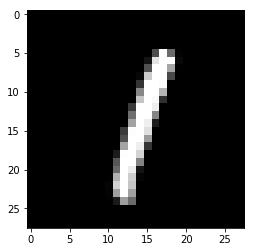

In [4]:
%matplotlib inline
x_img = x.reshape([28, 28])
plt.gray()
plt.imshow(x_img)

In [5]:
y = mnist.test.labels[5]
print(y)

1


Para começarmos a construir nossmo modelo, vamos definir o tamanho de cada camada da rede. No nosso exemplo vamos utilizar duas camadas ocultas: 
    <ul>
        <li><b>Camada 1</b>: com 300 neurônios</li>
        <li><b>Camada 2</b>: com 100 neurônios</li>
        <li><b>10 outputs</b>: um para cada classe (0, 1,..., 9) </li>
        <li><b>28x28 inputs</b>: imagem de 28x28 pixels</li>
    </ul>

In [6]:
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

Para enviarmos inputs externos ao modelo devemos criar os <b>placeholders</b>, que nada mais é que o valor que passaremos ao tensoflow quando executarmos o processo. <br>
Como entrada temos dois tensores: os valores de X, ou seja, os vetores de características de cada imagem e os valores de Y, que são os rótulos para cada uma delas

In [7]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

Ao definirmos as dimensões dos tensores como (None, n_inputs) estamos falando que queremos um tensor de forma (tamanho qualquer necessário, 784), uma vez que o número de linhas é definido pelo número de exemplos no treinamento, porém o tamanho do vetor de característica já está definido como 784

O tensorflow nos permite agrupar varíaveis relacionadas para facilitar o trabalho em modelos complexos, criado um escopo ao qual cada uma pertence. Neste exemplo vamos agrupá-las de acordo com: variáveis das camadas da rede (dnn), variáveis de otimização (loss), variáveis de treinamento (train) e de teste (test)

Abaixo criamos as camadas da rede, note que utilizamos os objetos fully_connected, do pacote contrib, o qual já cria os neurônios, funções de ativação e conexões para minha rede neural. Veja também que a camada anterior vira entrada para a camada seguinte é a última camada antes de passar pela função de ativação, que será uma softmax para gerar distribuição de probabilidade

Por motivos de otimização não utilizamos a softmax durante o processo de treinamento, uma vez que a função de loss utilizada lida apenas com os logits(entrada da softmax) https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits 

In [8]:
with tf.name_scope("dnn"):
    hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
    hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")
    logits = fully_connected(hidden2, n_outputs, scope="outputs", activation_fn=None)

Para treinarmos um modelo, devemos indicar para o computador o que significa uma classificação boa uma ruim, matematicamente isto é representado por uma função de custo, ou loss, que indica o quão distante nossa predição está do desejado.

Utilizamos a função de loss cross-entropy, uma vez que estamos tratando de um problema de classificação, que é definida por:

$H_{y'}(y) = -\sum_{i}{y_i'log(y_i)}$

onde $y'$ é a distribuição predita e $y$ é a verdadeira distribuição

A nossa loss por iteração é a média das losses de cada exemplo/batch

In [9]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

Já montamos a estrutura da rede e definimos nossa função de custo, agora vamos configurar o treinamento da nossa rede neural. O tensorflow já possui um método para realizar a otimização de nossa função de custo por meio do Gradiente Descendente <br>
Setamos nosso optimizer para minimizar a função de custo (loss) definida anteriormente

In [10]:
learning_rate = 0.1
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

O próximo passo é construir o processo de avaliação. Note que nossa marcação de acertos utiliza o método in_top_k(), que quer dizer "se o classe real está entre os k primeiros (mais prováveis) que meu modelo previu, está correto". Como o que nos importa é se acertamos a mais provável, enviamos o valor 1 para a função, definindo um top 1. <br>
Por fim, nossa acurácia (taxa de acerto) é a média de quantos acertamos pelo total.

In [11]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Agora devemos executar o grafo (processos) criado pelo tensroflow. Para isso devemos inicializar nossas variáveis e definirmos uma sessão.<br>
Feito isso, executamos o processo de aprendizado (minimização da loss) o número de épocas definido.

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
n_epochs = 100
batch_size = 50

In [14]:
with tf.Session() as sess:
    init.run()
    train_accs = []
    test_accs = []
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        loss_train = loss.eval(feed_dict={X: X_batch, y: y_batch})
        loss_test = loss.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        train_accs.append(acc_train)
        test_accs.append(acc_test)
        train_losses.append(loss_train)
        test_losses.append(loss_test)
    save_path = saver.save(sess, "./my_model_tf.ckpt")

0 Train accuracy: 0.98 Test accuracy: 0.9569
1 Train accuracy: 1.0 Test accuracy: 0.9636
2 Train accuracy: 0.96 Test accuracy: 0.9714
3 Train accuracy: 1.0 Test accuracy: 0.9729
4 Train accuracy: 1.0 Test accuracy: 0.9754
5 Train accuracy: 1.0 Test accuracy: 0.9764
6 Train accuracy: 1.0 Test accuracy: 0.9765
7 Train accuracy: 1.0 Test accuracy: 0.9783
8 Train accuracy: 1.0 Test accuracy: 0.9797
9 Train accuracy: 1.0 Test accuracy: 0.9798
10 Train accuracy: 1.0 Test accuracy: 0.9814
11 Train accuracy: 1.0 Test accuracy: 0.9808
12 Train accuracy: 1.0 Test accuracy: 0.9797
13 Train accuracy: 1.0 Test accuracy: 0.982
14 Train accuracy: 1.0 Test accuracy: 0.9812
15 Train accuracy: 1.0 Test accuracy: 0.9815
16 Train accuracy: 1.0 Test accuracy: 0.9815
17 Train accuracy: 1.0 Test accuracy: 0.9826
18 Train accuracy: 1.0 Test accuracy: 0.9816
19 Train accuracy: 1.0 Test accuracy: 0.9813
20 Train accuracy: 1.0 Test accuracy: 0.982
21 Train accuracy: 1.0 Test accuracy: 0.9823
22 Train accuracy: 1

Perceba que se não executarmos o método eval de nossas objetos no tensorflow não conseguimos obter o valor dele, o que obtemos é o próprio objeto. Portanto, sempre que precisarmos do valor do objeto devemos executá-lo

In [15]:
loss

<tf.Tensor 'loss/loss:0' shape=() dtype=float32>

Vamos visualizar nosso processo de treinamento da rede

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [17]:
trains = np.arange(len(train_accs))

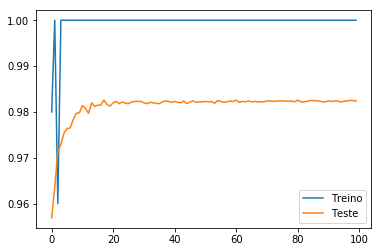

In [18]:
plt.plot(trains, train_accs, label="Treino")
plt.plot(trains, test_accs, label="Teste")
plt.legend()
plt.show()

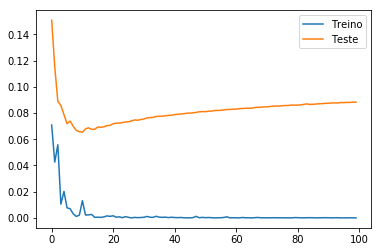

In [19]:
plt.plot(trains, train_losses, label="Treino")
plt.plot(trains, test_losses, label="Teste")
plt.legend()
plt.show()

Note que a oscilação dos valores de treino são bem maiores que no de teste, uma vez que os pesos estão sendo ajustados em função deles. É possível observar a convergência da rede ao longo do tempo (acurácia aumenta e loss diminui). <br>
As oscilações bruscas podem ser causadar por diveros motivos. Tente diminuir o valor da learning rate e executar novamente.

Agora que temos nosso modelo treinado, podemos classificar novas imagens.  Para isso, devemos carregar o modelo qe salvamos

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_tf.ckpt")
    x_new = mnist.test.images[5]
    Z = logits.eval(feed_dict={X: [x_new]})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_tf.ckpt


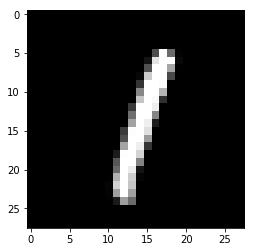

In [22]:
x_img = x_new.reshape([28, 28])
plt.gray()
plt.imshow(x_img)

In [23]:
y_pred[0]

1

Lembre-se que estamos trabalhando com os logits (valores de entrada da softmax). Se precisarmos predizer as probabilidades, devemos aplicar a softmax para normalização

In [24]:
probabilities = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, "./my_model_tf.ckpt")
    x_new = mnist.test.images[5]
    y_probs = probabilities.eval(feed_dict={X: [x_new]})    
    y_pred = np.argmax(y_probs, axis=1)    

INFO:tensorflow:Restoring parameters from ./my_model_tf.ckpt


A probabilidade pra cada classe é:

In [26]:
y_probs

array([[  5.40209079e-16,   9.99999881e-01,   2.95586336e-13,
          5.01862380e-14,   3.02528447e-09,   3.93857297e-16,
          4.83358377e-15,   1.17119093e-07,   1.02851427e-09,
          3.42836247e-14]], dtype=float32)

In [27]:
print("Classe predita %d com probabilidade %f" %(y_pred[0], np.max(y_probs)))

Classe predita 1 com probabilidade 1.000000


Veja abaixo uma ilustração de como a softmax transforma a saída da rede em um distribuição de probabilidade,usando os logits ou a proabilidade nos fornece o mesmo resultado para classificação:

<img src='imagens/softmax.png' width="500">